https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8565840

In [1]:
from utils import DatasetGenerator
from utils import getEnergyMap
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

(270, 360, 3)


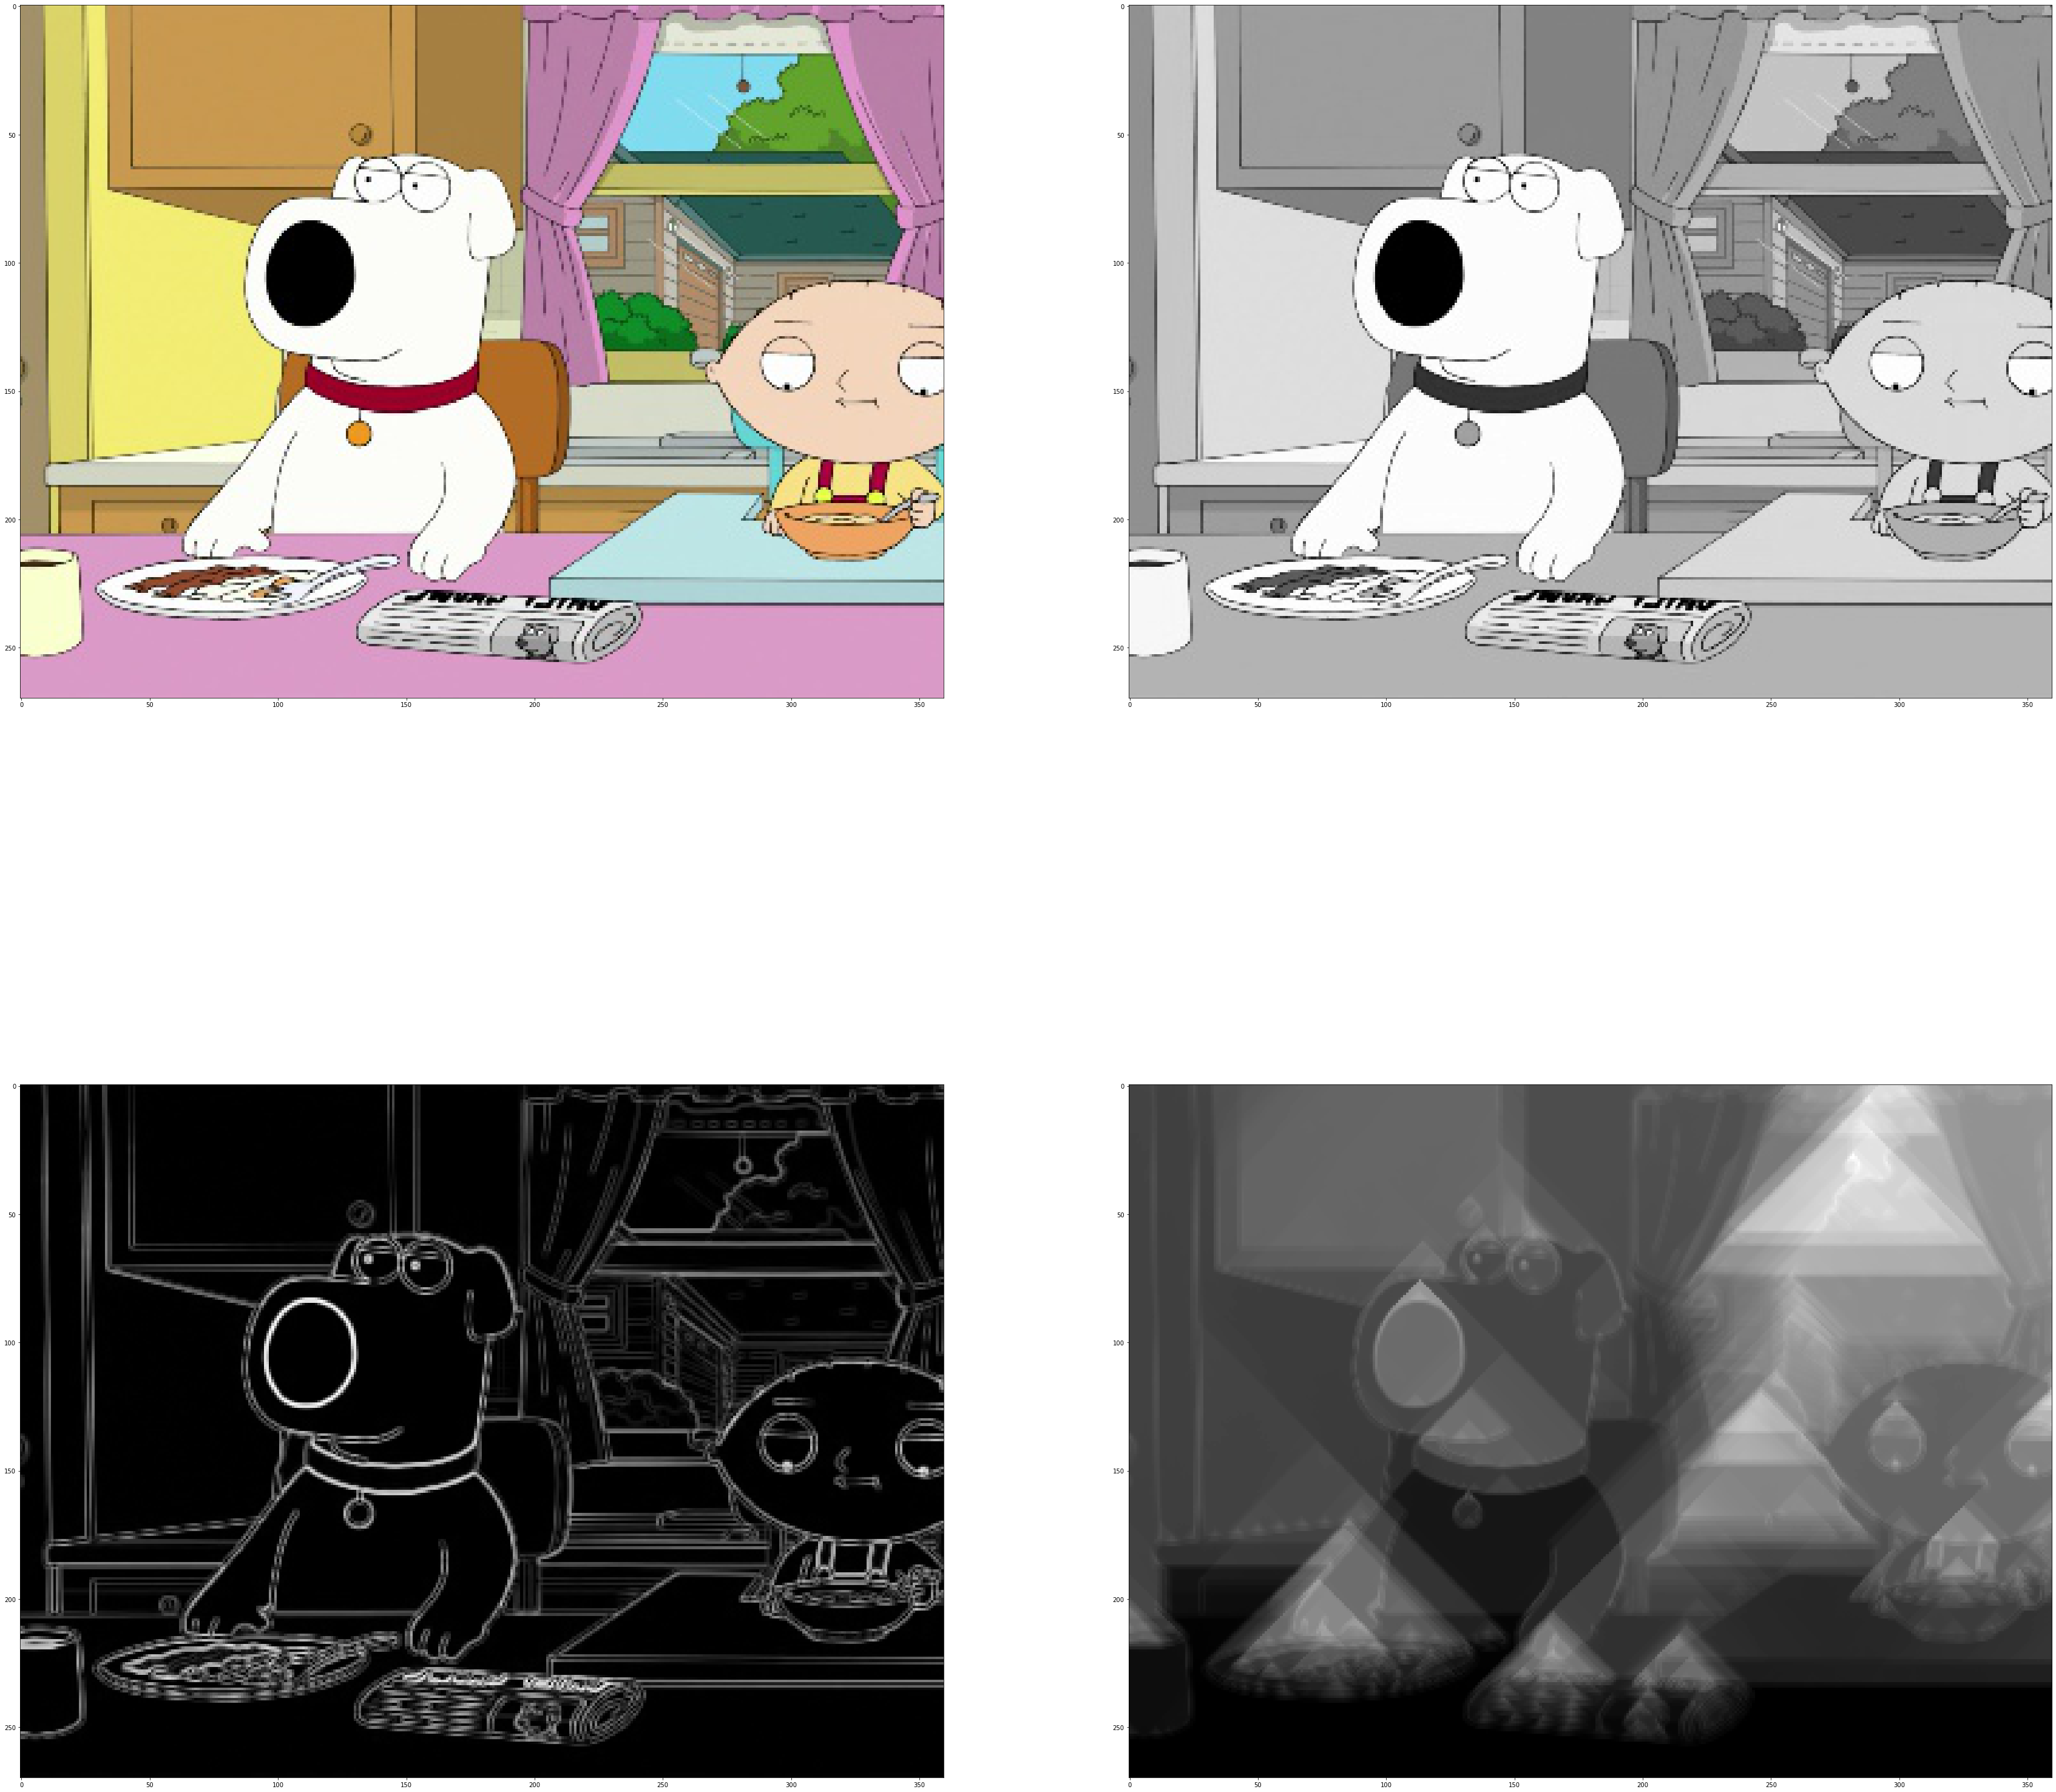

In [22]:
gen = DatasetGenerator("data/datasets/dataset_01/", shuffle=True)
X = gen.__getitem__(0)
plt.figure(figsize=(60, 60))
print(X[0].shape)
grey, energy, memorization = getEnergyMap(X[0])
ax = plt.subplot(2, 2, 1)
plt.imshow(X[0].astype(np.uint8))
ax = plt.subplot(2, 2, 2)
plt.imshow(grey, cmap='gray')
ax = plt.subplot(2, 2, 3)
plt.imshow(energy, cmap='gray')
ax = plt.subplot(2, 2, 4)
plt.imshow(memorization, cmap='gray')
del gen
del X

In [28]:
class DownBlock(tf.keras.Model):
    def __init__(self, filters, kernel, padding='same', strides=[1, 1], activation=tf.nn.relu):
        super(DownBlock, self).__init__()
        for i in range(0, 2):
            vars(self)[f'conv2D_{i}'] = tf.keras.layers.Conv2D(filters, kernel, padding=padding,
                                                                strides=strides[i], activation=activation)
        self.max_pool = tf.keras.layers.MaxPooling2D()

    def call(self, inputs):
        x = self.conv2D_0(inputs)
        x = self.conv2D_1(x)
        x = self.max_pool(x)
        return x

class BottleNeck(tf.keras.Model):
    def __init__(self, filters, kernel, padding='same', strides=[1, 1], activation=tf.nn.relu):
        super(BottleNeck, self).__init__()
        for i in range(0, 2):
            vars(self)[f'conv2D_{i}'] = tf.keras.layers.Conv2D(filters, kernel, padding=padding,
                                                                strides=strides[i], activation=activation)
        self.upConv = tf.keras.layers.Conv2DTranspose(filters//2, kernel, padding='same', activation=None)

    def call(self, inputs):
        x = self.conv2D_0(inputs)
        x = self.conv2D_1(x)
        x = self.upConv(x)
        return x

class UpBlock(tf.keras.Model):
    def __init__(self, filters, kernel, padding='same', strides=[1, 1], activation=tf.nn.relu):
        super(UpBlock, self).__init__()
        self.upConv2D = tf.keras.layers.Conv2DTranspose(filters, kernel, padding=padding, strides=2,
                                                        activation=None)
        for i in range(0, 2):
            vars(self)[f'conv2D_{i}'] = tf.keras.layers.Conv2D(filters, kernel, padding=padding,
                                                                strides=strides[i], activation=activation)
    def call(self, inputs):
        x = self.upConv2D(inputs)
        x = self.conv2D_0(x)
        x = self.conv2D_1(x)
        return x
        
class SowNet(tf.keras.Model):
    def __init__(self, input_shape):
        super(SowNet, self).__init__()
        for i in range(1, 5):
            vars(self)[f'encoder_layer_{i}'] = DownBlock(32 * (2**(i-1)), 3)
        self.bottleneck = BottleNeck(512, 3)
        for i in range(4, 0, -1):
            vars(self)[f'decoder_layer_{i}'] = UpBlock(32 * (2**(i-1)), 3)
        self.outputs = tf.keras.layers.Conv2D(1, 1, activation=tf.nn.sigmoid)
        # self.call(tf.keras.layers.Input(shape=input_shape))

    def call(self, inputs):
        encode_1 = self.encoder_layer_1(inputs)
        encode_2 = self.encoder_layer_2(encode_1)
        encode_3 = self.encoder_layer_3(encode_2)
        encode_4 = self.encoder_layer_4(encode_3)
        bottle = self.bottleneck(encode_4)
        add_4_bottle = tf.keras.layers.add([encode_4, bottle])
        decode_4 = self.decoder_layer_4(add_4_bottle)
        encode_3 = tf.keras.layers.concatenate([encode_3, encode_3], axis=3)
        decode_4 = tf.keras.layers.ZeroPadding2D(padding=((0,1),(0,1)))(decode_4)
        add_3_4 = tf.keras.layers.add([encode_3, decode_4])
        decode_3 = self.decoder_layer_3(add_3_4)
        encode_2 = tf.keras.layers.concatenate([encode_2, encode_2], axis=3)
        decode_3 = tf.keras.layers.ZeroPadding2D(padding=((0,0),(0,1)))(decode_3)
        add_2_3 = tf.keras.layers.add([encode_2, decode_3])
        decode_2 = self.decoder_layer_2(add_2_3)
        encode_1 = tf.keras.layers.concatenate([encode_1, encode_1], axis=3)
        decode_2 = tf.keras.layers.ZeroPadding2D(padding=((0,0),(0,1)))(decode_2)
        add_1_2 = tf.keras.layers.add([encode_1, decode_2])
        decode_1 = self.decoder_layer_1(add_1_2)
        return self.outputs(decode_1)

model = SowNet((360, 270, 3))
model.build((32,360,270,3))
model.summary()
# down = DownBlock(32, 3)
# down.build((32, 360, 270, 3))
# tf.keras.utils.plot_model(down)

Model: "sow_net_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bottle_neck_26 (BottleNeck)  multiple                  1179904   
_________________________________________________________________
conv2d_490 (Conv2D)          multiple                  33        
Total params: 1,179,937
Trainable params: 1,179,937
Non-trainable params: 0
_________________________________________________________________
